<a href="https://colab.research.google.com/github/hashirmohammad/JigsawCommentClassification/blob/main/jigsawCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages installation

In [ ]:
pip install numpy pandas scikit-learn nltk xgboost matplotlib seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Distribution

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/MLProject/data/train.csv")
df.head()

Mounted at /content/drive


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Text(0.5, 1.0, 'label frequencies')

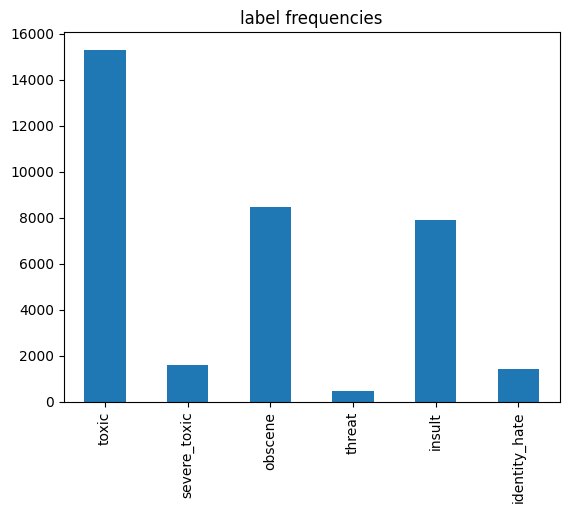

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[labels].sum().plot(kind='bar')
plt.title("label frequencies")

<Axes: >

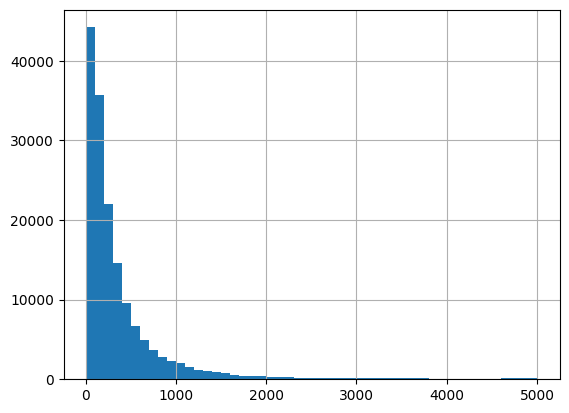

In [ ]:
df["length"] = df["comment_text"].str.len()
df["length"].hist(bins=50)

In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MLProject')
from src.preprocess import clean_text
df["comment_text"] = df["comment_text"].apply(clean_text)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df["comment_text"],
    df[labels],
    test_size=0.1,
    random_state=42
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)


Baseline Model (Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

clf = MultiOutputClassifier(
    LogisticRegression(max_iter=2000, class_weight="balanced")
)

clf.fit(X_train_tfidf, y_train)


MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=2000))

# Test Data


In [ ]:
drive.mount('/content/drive')

test = pd.read_csv("/content/drive/MyDrive/MLProject/data/test.csv")
test_labels = pd.read_csv("/content/drive/MyDrive/MLProject/data/test_labels.csv")

test.head()
test_labels.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test["comment_text"] = test["comment_text"].apply(clean_text)
X_test_tfidf = tfidf.transform(test["comment_text"])


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Re-initialize and fit the classifier to ensure it's fitted
clf = MultiOutputClassifier(
    LogisticRegression(max_iter=2000, class_weight="balanced")
)
clf.fit(X_train_tfidf, y_train)

# Get probabilities for all labels directly from MultiOutputClassifier
y_test_pred_probas_list = clf.predict_proba(X_test_tfidf)

# Extract the probability of the positive class (index 1) for each label
y_test_pred_proba = np.array([probas[:, 1] for probas in y_test_pred_probas_list]).T

In [ ]:
y_test_pred = (y_test_pred_proba > 0.5).astype(int)


In [ ]:
mask = (test_labels[labels] != -1).all(axis=1)

test_labels_clean = test_labels.loc[mask, labels]
y_test_pred_clean = y_test_pred[mask]


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_test = roc_auc_score(test_labels_clean, y_test_pred_proba[mask], average="macro")
print("Test ROC-AUC:", roc_auc_test)


Test ROC-AUC: 0.9729686004602255


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels_clean, y_test_pred_clean, target_names=labels))



               precision    recall  f1-score   support

        toxic       0.43      0.91      0.59      6090
 severe_toxic       0.14      0.89      0.23       367
      obscene       0.45      0.88      0.59      3691
       threat       0.17      0.82      0.28       211
       insult       0.38      0.87      0.53      3427
identity_hate       0.21      0.82      0.33       712

    micro avg       0.38      0.88      0.53     14498
    macro avg       0.30      0.86      0.43     14498
 weighted avg       0.40      0.88      0.55     14498
  samples avg       0.06      0.08      0.07     14498



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score
y_val_pred = clf.predict(X_val_tfidf)

# Subset accuracy: all labels must match exactly
subset_acc = accuracy_score(y_val, y_val_pred)
print("Overall subset validation accuracy:", subset_acc)


Overall subset validation accuracy: 0.8796841709487404
